Практическая работа № 6

Выполнил студент группы ББМО-01-23: Панков.Н.О

Цель работы:

1. Загрузить несколько моделей, обученных на датасете MNIST.
2. Изучить теоретические основы атаки по переносу.
3. Реализовать атаку FGSM на одну модель и проверить, как противоречивые примеры влияют на
другую модель.
4. Оценить точность обеих моделей на противоречивых примерах и проанализировать
переносимость атак.

In [7]:
# Импорт всех необходимых библиотек
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Загрузка и подготовка данных
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

# Модель 1: Полносвязная нейронная сеть
model1 = Sequential([Flatten(input_shape=(28, 28)), Dense(128, activation='relu'), Dense(10, activation='softmax')])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.fit(train_images, train_labels, epochs=5)
model1.save('mnist_model_1.h5')

# Модель 2: Свёрточная нейронная сеть (CNN)
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=5)
model2.save('mnist_model_2.h5')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8775 - loss: 0.4322
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9645 - loss: 0.1247
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9746 - loss: 0.0814
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9822 - loss: 0.0597
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9860 - loss: 0.0451


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - accuracy: 0.9130 - loss: 0.2887
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.9837 - loss: 0.0532
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 23ms/step - accuracy: 0.9898 - loss: 0.0311
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.9940 - loss: 0.0193
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.9954 - loss: 0.0124


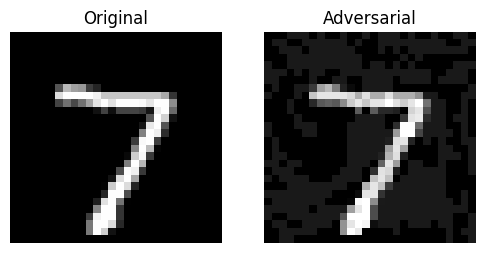

In [8]:
# Функция FGSM атаки
def fgsm_attack(image, epsilon, gradient):
    return np.clip(image + epsilon * np.sign(gradient), 0, 1)

# Генерация одного противоречивого примера
def generate_adversarial_example(model, image, label, epsilon):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
    label = tf.convert_to_tensor(np.argmax(label) if len(label.shape) > 1 else label)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)
    gradient = tape.gradient(loss, image)
    return fgsm_attack(image.numpy(), epsilon, gradient.numpy()).reshape(28, 28)

# Генерация множества противоречивых примеров
def generate_adversarial_dataset(model, images, labels, epsilon):
    return np.array([generate_adversarial_example(model, img, lbl, epsilon) for img, lbl in zip(images, labels)])

# Генерация противоречивых примеров и отображение до/после
epsilon = 0.1
adversarial_images_model1 = generate_adversarial_dataset(model1, test_images, test_labels, epsilon)

# Отображение оригинального и противоречивого изображения
idx = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(test_images[idx], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Adversarial")
plt.imshow(adversarial_images_model1[idx], cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# Оценка моделей на противоречивых примерах
acc1 = model1.evaluate(adversarial_images_model1, test_labels, verbose=0)[1]
acc2 = model2.evaluate(adversarial_images_model1.reshape(-1, 28, 28, 1), test_labels, verbose=0)[1]

print(f'Model1 Accuracy on Adversarial Examples: {acc1}')
print(f'Model2 Accuracy on Transferred Adversarial Examples: {acc2}')

Model1 Accuracy on Adversarial Examples: 0.1216999962925911
Model2 Accuracy on Transferred Adversarial Examples: 0.965499997138977


In [10]:
# Генерация и оценка противоречивых примеров от model2
adversarial_images_model2 = generate_adversarial_dataset(model2, test_images.reshape(-1, 28, 28, 1), test_labels, epsilon)
acc3 = model1.evaluate(adversarial_images_model2.reshape(-1, 28, 28), test_labels, verbose=0)[1]

print(f'Model1 Accuracy on Adversarial Examples from Model2: {acc3}')

Model1 Accuracy on Adversarial Examples from Model2: 0.9172000288963318


Вывод:

В ходе работы было исследовано воздействие атаки по переносу, при которой противоречивые примеры, созданные для одной модели, использовались для атаки на другую. Метод FGSM позволил эффективно генерировать такие примеры, искажающие предсказания.

Результаты эксперимента показали, что точность модели 1 резко упала до 12.17% на её собственных противоречивых примерах, что свидетельствует о высокой уязвимости к атакам. Однако модель 2, протестированная на тех же примерах, сохранила точность на уровне 96.55%, продемонстрировав значительную устойчивость к переносу атак.

Когда противоречивые примеры были сгенерированы для модели 2 и использованы против модели 1, точность последней снизилась до 91.72%, что меньше, чем в первом случае, и подтверждает её меньшую восприимчивость к атакам, созданным для другой модели.

Эти результаты показывают, что атака по переносу с использованием FGSM может существенно снизить точность, особенно если примеры созданы для целевой модели. В то же время, более устойчивые модели сохраняют точность при воздействии атак, перенесённых с других моделей, подчёркивая важность разработки методов защиты от таких атак.